# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime

In [2]:
train_data = pd.read_excel("datasets/train.xlsx")
test_data = pd.read_excel("datasets/test.xlsx")

In [3]:
train_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,558904,22292,HANGING CHICK YELLOW DECORATION,1,2011-07-04 16:18:00,1.25,NaN,United Kingdom
1,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,16126.0,United Kingdom
2,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,18118.0,United Kingdom
3,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,15529.0,United Kingdom
4,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,14448.0,United Kingdom
...,...,...,...,...,...,...,...,...
379331,C554864,22962,JAM JAR WITH PINK LID,-4,2011-05-27 10:36:00,0.85,15122.0,United Kingdom
379332,539451,20749,ASSORTED COLOUR MINI CASES,1,2010-12-17 16:59:00,16.98,NaN,United Kingdom
379333,572302,22091,EMPIRE TISSUE BOX,1,2011-10-23 14:47:00,0.39,15427.0,United Kingdom
379334,559339,84946,ANTIQUE SILVER T-LIGHT GLASS,60,2011-07-07 16:49:00,1.25,13752.0,United Kingdom


In [4]:
def clean_data(df):
    df = df.dropna(subset=['CustomerID']) 
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]  
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    return df

train_data = clean_data(train_data)
test_data = clean_data(test_data)

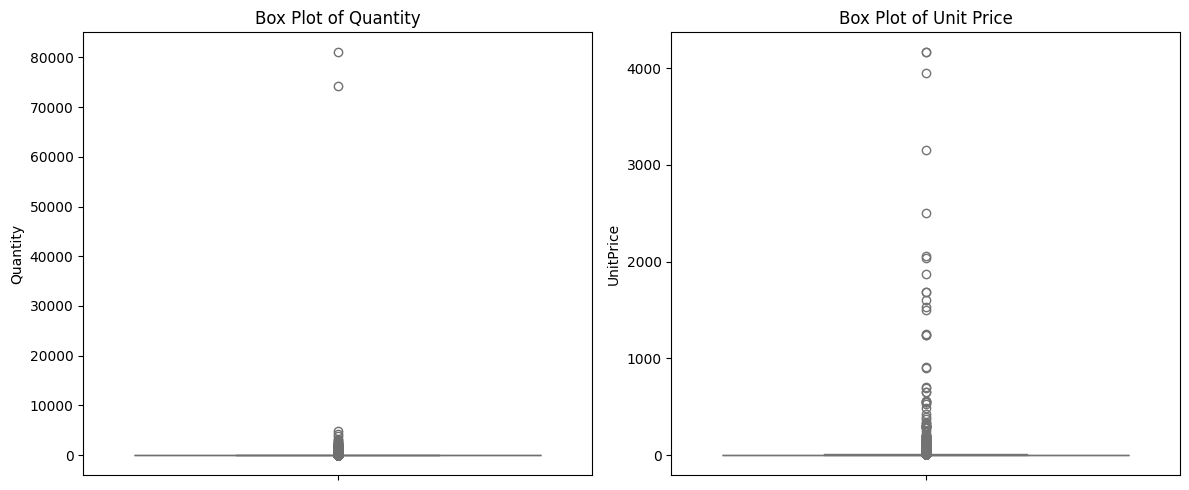

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=train_data['Quantity'], ax=axes[0], color='skyblue')
axes[0].set_title("Box Plot of Quantity")

sns.boxplot(y=train_data['UnitPrice'], ax=axes[1], color='lightgreen')
axes[1].set_title("Box Plot of Unit Price")

plt.tight_layout()
plt.show()

Data is highly skewed! 

#### Feature Engineering

In [6]:
def create_rfm(df):
    last_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (last_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})
    return rfm

rfm_train = create_rfm(train_data)
rfm_test = create_rfm(test_data)


Let's address the skewness problem!

In [7]:
rfm_train_log = np.log1p(rfm_train)
rfm_test_log = np.log1p(rfm_test)

scaler = StandardScaler()
rfm_train_scaled = scaler.fit_transform(rfm_train_log)
rfm_test_scaled = scaler.transform(rfm_test_log)


#### k-means

In [8]:
wcss = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_train_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_train_scaled, kmeans.labels_))

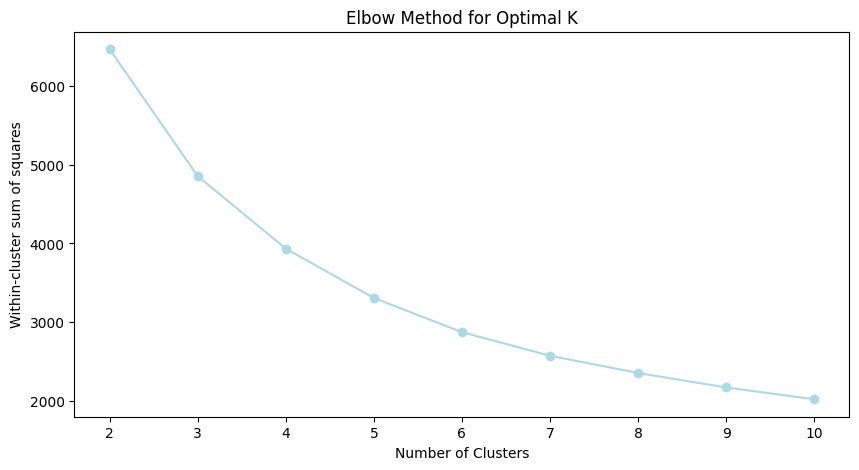

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, color='lightblue', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method for Optimal K')
plt.show()

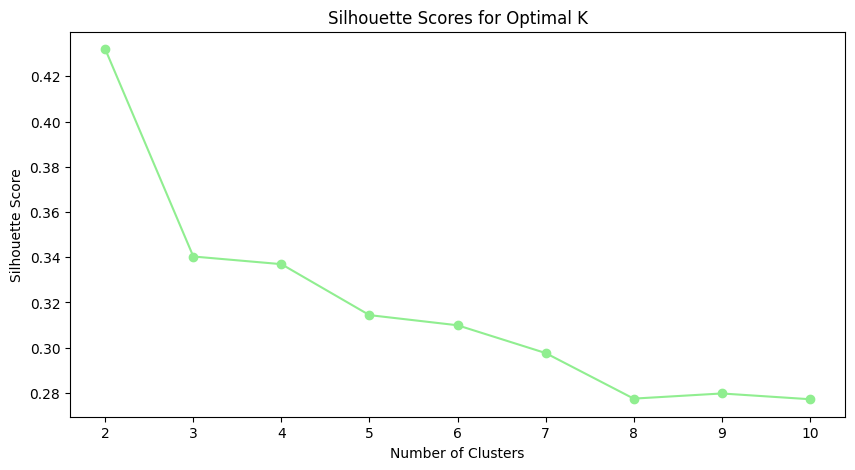

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='lightgreen')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal K')
plt.show()


Analyzing the Elbow Method and Silhouette gives us the optimal cluster number of 4.

In [11]:
optimal_k = 4  

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_train['Cluster'] = kmeans.fit_predict(rfm_train_scaled)
rfm_test['Cluster'] = kmeans.predict(rfm_test_scaled)


In [12]:
rfm_train_grouped = rfm_train.groupby('Cluster').mean()
rfm_test_grouped = rfm_test.groupby('Cluster').mean()

print("Training Data Cluster Summary:\n", rfm_train_grouped)
print("\nTest Data Cluster Summary:\n", rfm_test_grouped)

Training Data Cluster Summary:
             Recency  Frequency     Monetary
Cluster                                    
0         19.294326   2.042553   369.003109
1        185.044045   1.310174   250.327674
2         67.635043   4.115385  1335.906609
3         11.699422  13.497110  5811.195592

Test Data Cluster Summary:
             Recency  Frequency     Monetary
Cluster                                    
0         19.168675   2.570899   234.310232
1        169.679025   1.434322   135.299662
2         60.748988   5.124157   771.327314
3          9.725410  14.836066  3138.370779


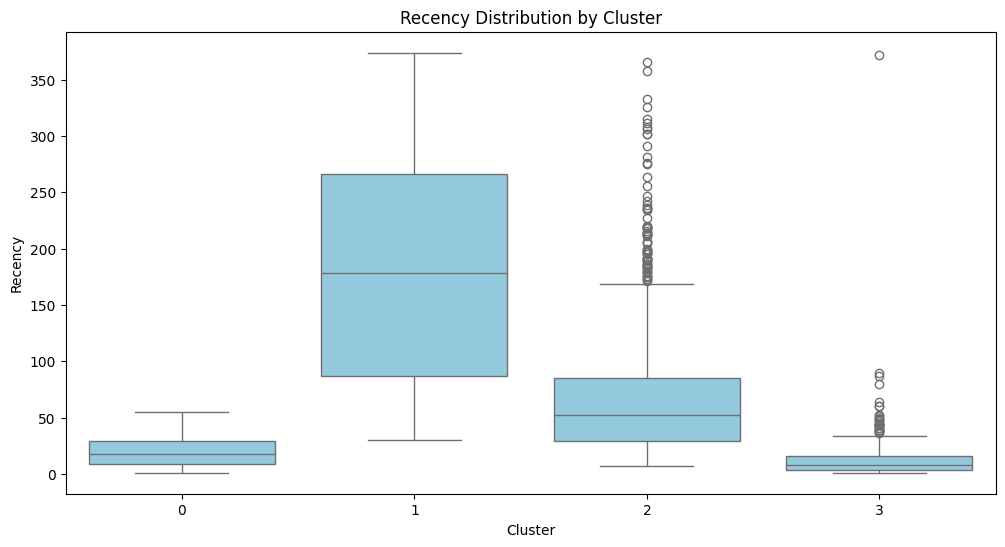

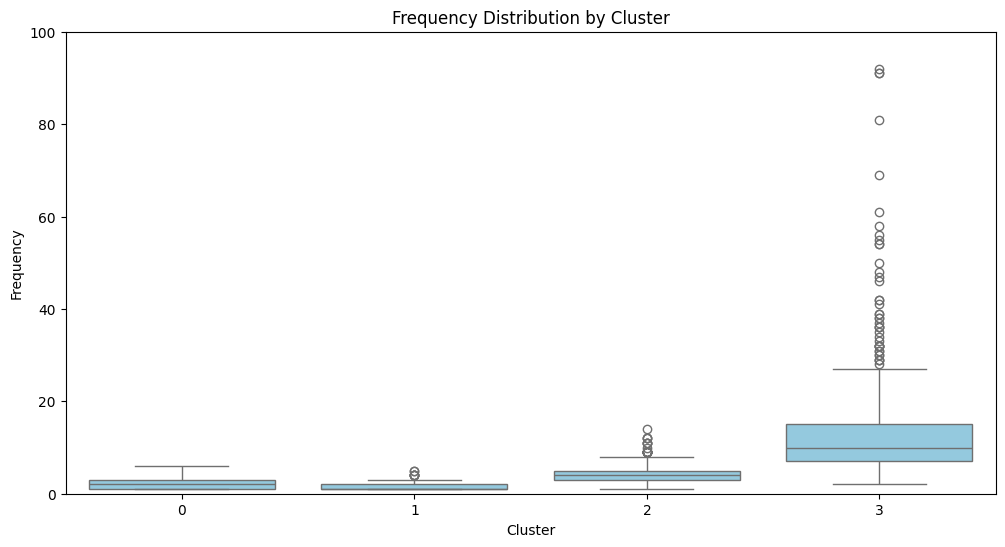

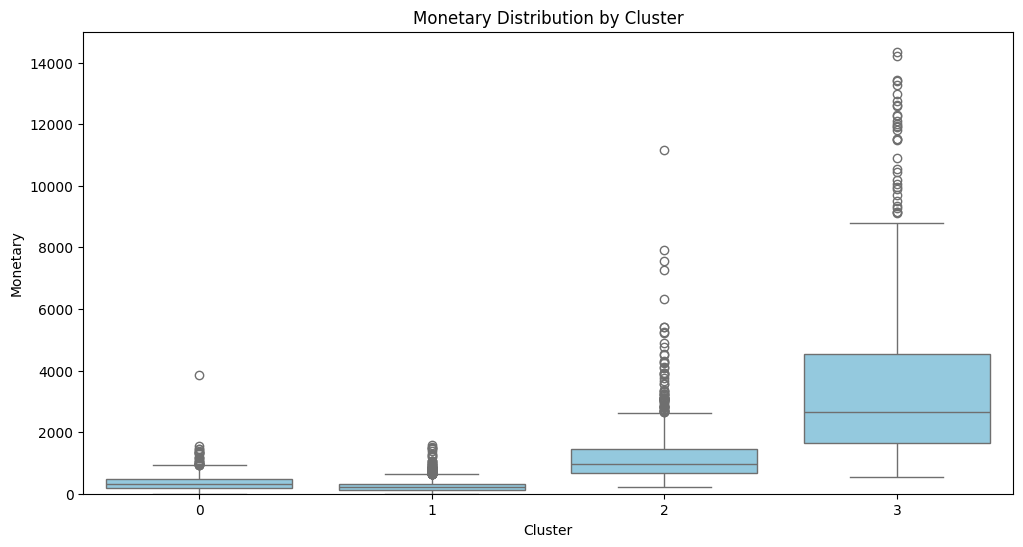

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Recency', color='skyblue', data=rfm_train.reset_index())
plt.title("Recency Distribution by Cluster")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Frequency', color='skyblue', data=rfm_train.reset_index())
plt.title("Frequency Distribution by Cluster")
plt.ylim([0,100])
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Monetary', color='skyblue', data=rfm_train.reset_index())
plt.title("Monetary Distribution by Cluster")
plt.ylim([0,15000])
plt.show()